Using this tutorial for seurat (SeuratV4.3.0)[https://satijalab.org/seurat/archive/v4.3/pbmc3k_tutorial]

In [1]:
library(dplyr)
library(Seurat)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 

Attaching SeuratObject



using functions from Tony's tutorial

In [2]:
# save stuff here
data_path <- "/pub/mbarcen1/EE283/hw10/data/"
fig_path <- "/pub/mbarcen1/EE283/hw10/figs/"

# Convenience functions
SaveFigure <- function(plots, name, type = "png", width, height, res){
  if(type == "png") {
    png(paste0(fig_path, name, ".", type),
      width = width, height = height, units = "in", res = 200)
  } else {
    pdf(paste0(fig_path, name, ".", type),
      width = width, height = height)
}
print(plots)
dev.off()
}

SaveObject <- function(object, name){
  saveRDS(object, paste0(data_path, name, ".RDS"))
}

ReadObject <- function(name){
  readRDS(paste0(data_path, name, ".RDS"))
}


Since I do not have a dataset that is ready to work with I am using installed Seurat datasets

In [3]:
# Load the PBMC dataset
pbmc.data <- Read10X(data.dir = "/pub/mbarcen1/EE283/hw10/data/pbmc3k/filtered_gene_bc_matrices/hg19/")
# Initialize the Seurat object with the raw (non-normalized data).
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)
pbmc

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)

## Standard pre-processing workflow

In [4]:
# The [[ operator can add columns to object metadata. This is a great place to stash QC stats
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

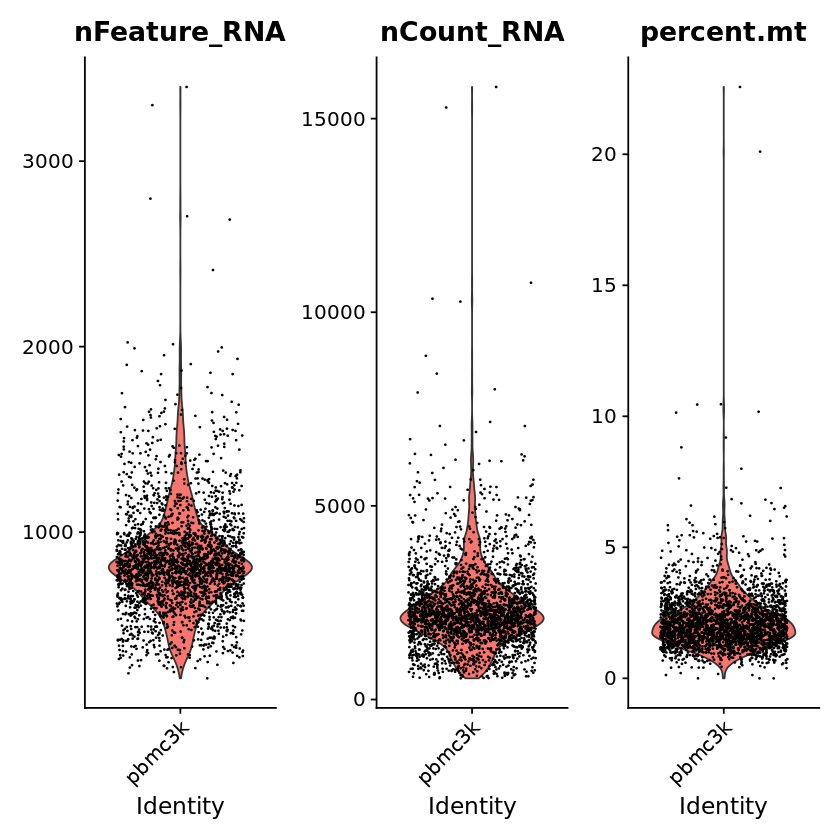

In [5]:
# Visualize QC metrics as a violin plot
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

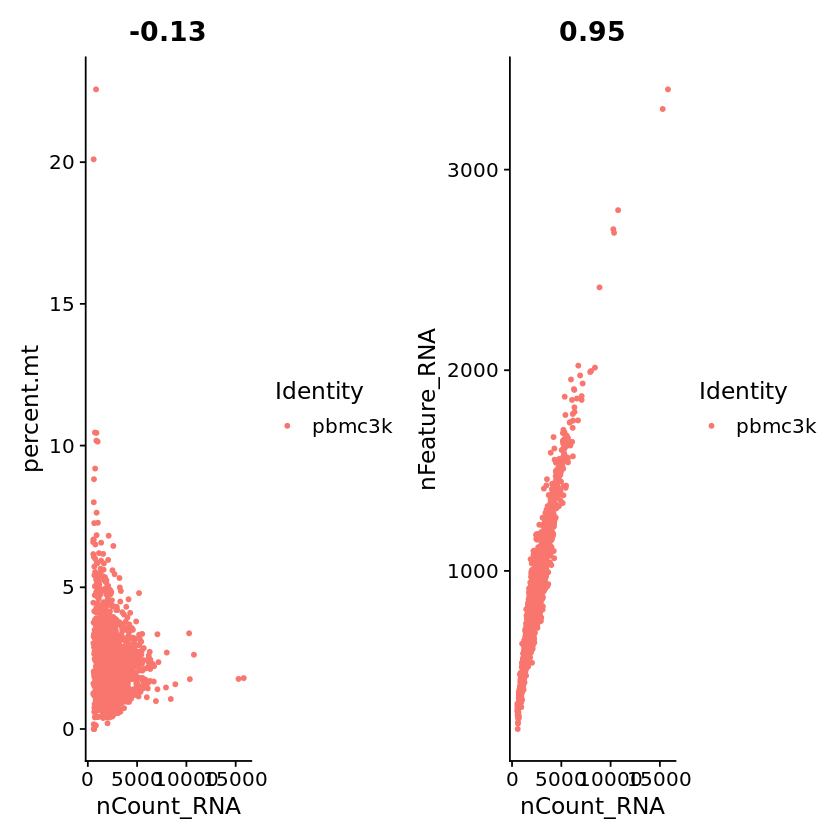

In [6]:
# FeatureScatter is typically used to visualize feature-feature relationships, but can be used
# for anything calculated by the object, i.e. columns in object metadata, PC scores etc.

plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

In [7]:
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

## Normalizing the data

In [8]:
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)

## Identification of highly variable features (feature selection)

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”


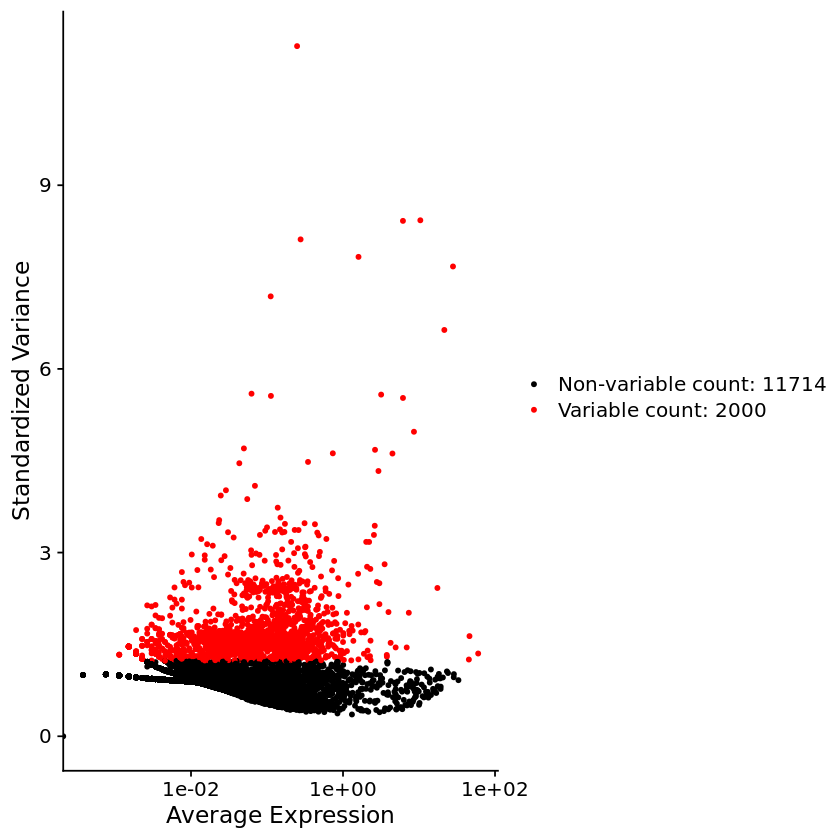

In [10]:
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(pbmc), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(pbmc)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1

Warning message:
“Transformation introduced infinite values in continuous x-axis”


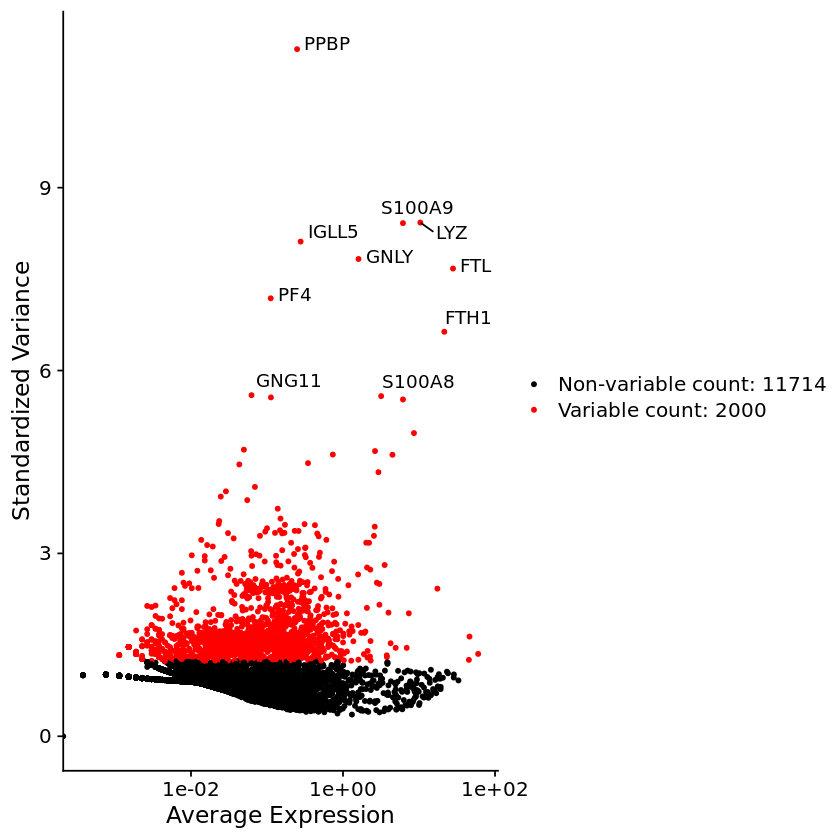

In [11]:
plot2

## Scaling data

In [12]:
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)

Centering and scaling data matrix



## Perform linear dimensional reduction

In [13]:
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL, FTH1, LYZ, FCN1, S100A9, TYMP 
	   FCER1G, CFD, LGALS1, S100A8, CTSS, LGALS2, SERPINA1, IFITM3, SPI1, CFP 
	   PSAP, IFI30, SAT1, COTL1, S100A11, NPC2, GRN, LGALS3, GSTP1, PYCARD 
Negative:  MALAT1, LTB, IL32, IL7R, CD2, B2M, ACAP1, CD27, STK17A, CTSW 
	   CD247, GIMAP5, AQP3, CCL5, SELL, TRAF3IP3, GZMA, MAL, CST7, ITM2A 
	   MYC, GIMAP7, HOPX, BEX2, LDLRAP1, GZMK, ETS1, ZAP70, TNFAIP8, RIC3 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1, HLA-DRA, LINC00926, CD79B, HLA-DRB1, CD74 
	   HLA-DMA, HLA-DPB1, HLA-DQA2, CD37, HLA-DRB5, HLA-DMB, HLA-DPA1, FCRLA, HVCN1, LTB 
	   BLNK, P2RX5, IGLL5, IRF8, SWAP70, ARHGAP24, FCGR2B, SMIM14, PPP1R14A, C16orf74 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA, FGFBP2, CTSW, GNLY, B2M, SPON2 
	   CCL4, GZMH, FCGR3A, CCL5, CD247, XCL2, CLIC3, AKR1C3, SRGN, HOPX 
	   TTC38, APMAP, CTSC, S100A4, IGFBP7, ANXA1, ID2, IL32, XCL1, RHOC 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1, HLA-DPA

In [14]:
# Examine and visualize PCA results a few different ways
print(pbmc[["pca"]], dims = 1:5, nfeatures = 5)

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL 
Negative:  MALAT1, LTB, IL32, IL7R, CD2 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1 
Negative:  PPBP, PF4, SDPR, SPARC, GNG11 
PC_ 4 
Positive:  HLA-DQA1, CD79B, CD79A, MS4A1, HLA-DQB1 
Negative:  VIM, IL7R, S100A6, IL32, S100A8 
PC_ 5 
Positive:  GZMB, NKG7, S100A8, FGFBP2, GNLY 
Negative:  LTB, IL7R, CKB, VIM, MS4A7 


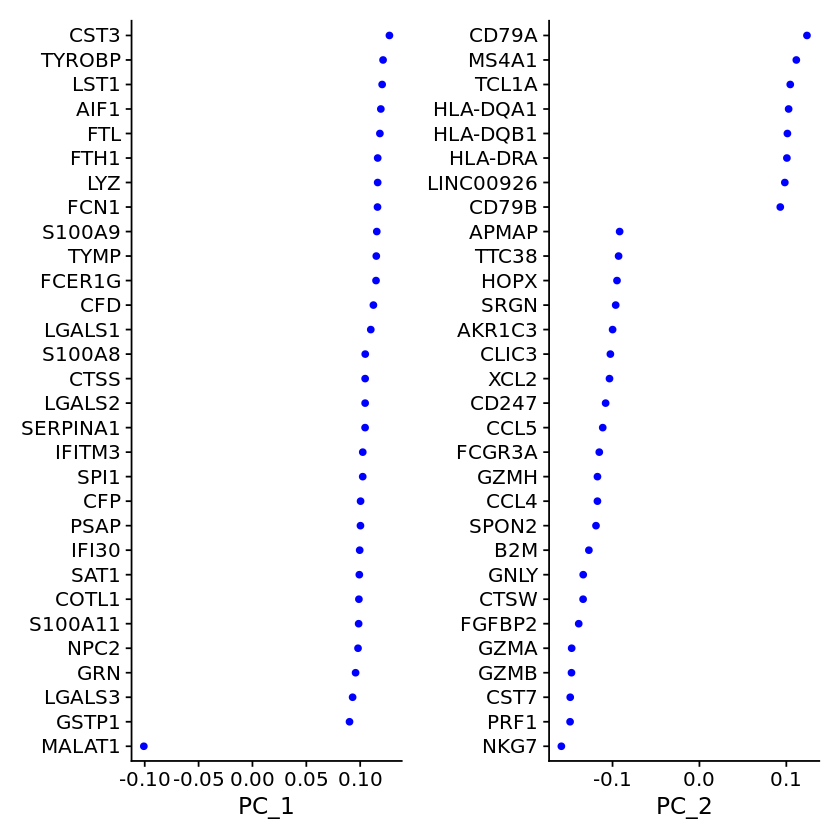

In [15]:
VizDimLoadings(pbmc, dims = 1:2, reduction = "pca")

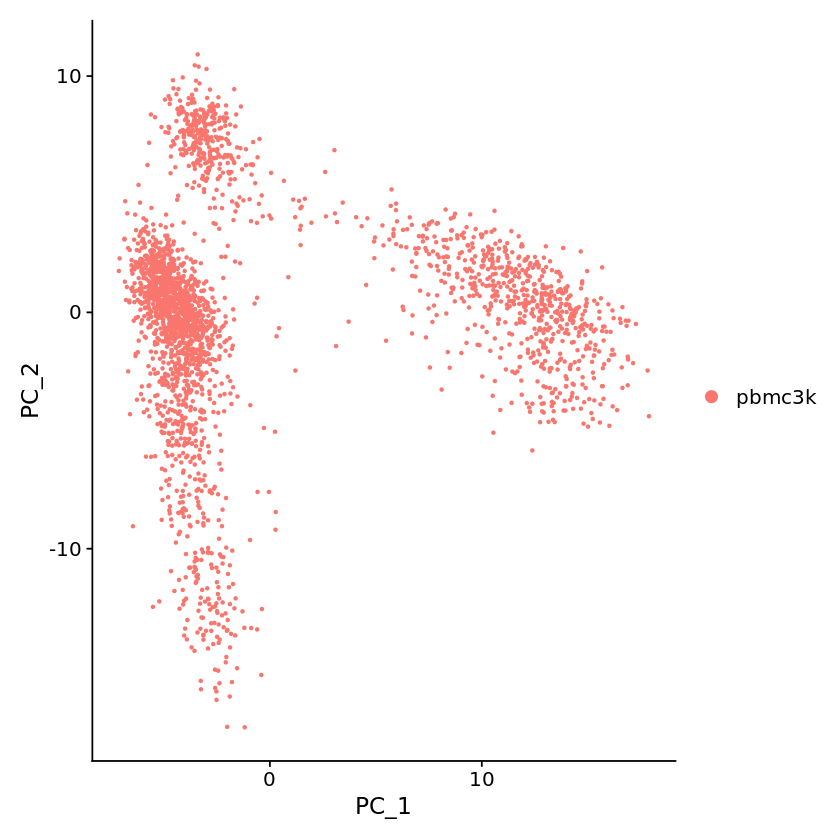

In [16]:
DimPlot(pbmc, reduction = "pca")

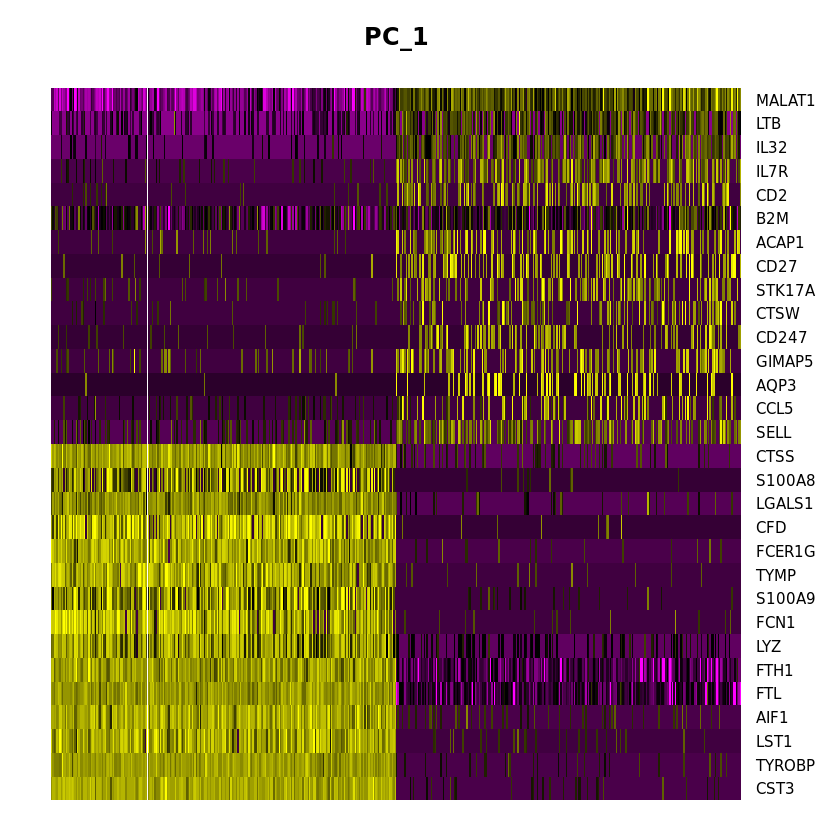

In [17]:
DimHeatmap(pbmc, dims = 1, cells = 500, balanced = TRUE)

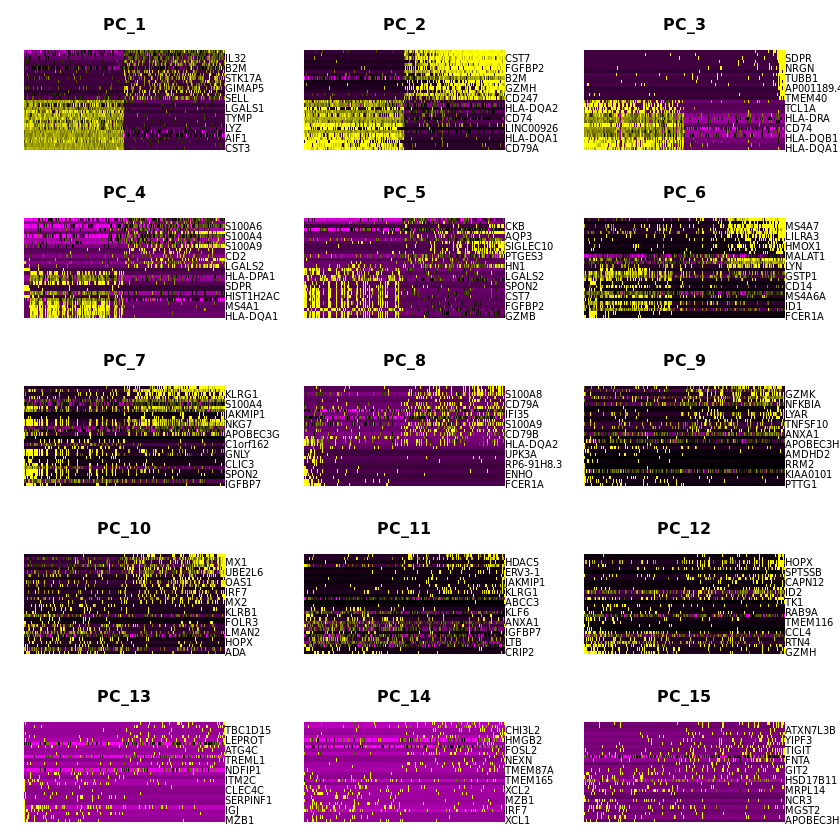

In [18]:
DimHeatmap(pbmc, dims = 1:15, cells = 500, balanced = TRUE)

## Determine the 'dimensionality' of the dataset

In [19]:
# NOTE: This process can take a long time for big datasets, comment out for expediency. More
# approximate techniques such as those implemented in ElbowPlot() can be used to reduce
# computation time
pbmc <- JackStraw(pbmc, num.replicate = 100)
pbmc <- ScoreJackStraw(pbmc, dims = 1:20)

Warning message:
“Removed 23489 rows containing missing values (`geom_point()`).”


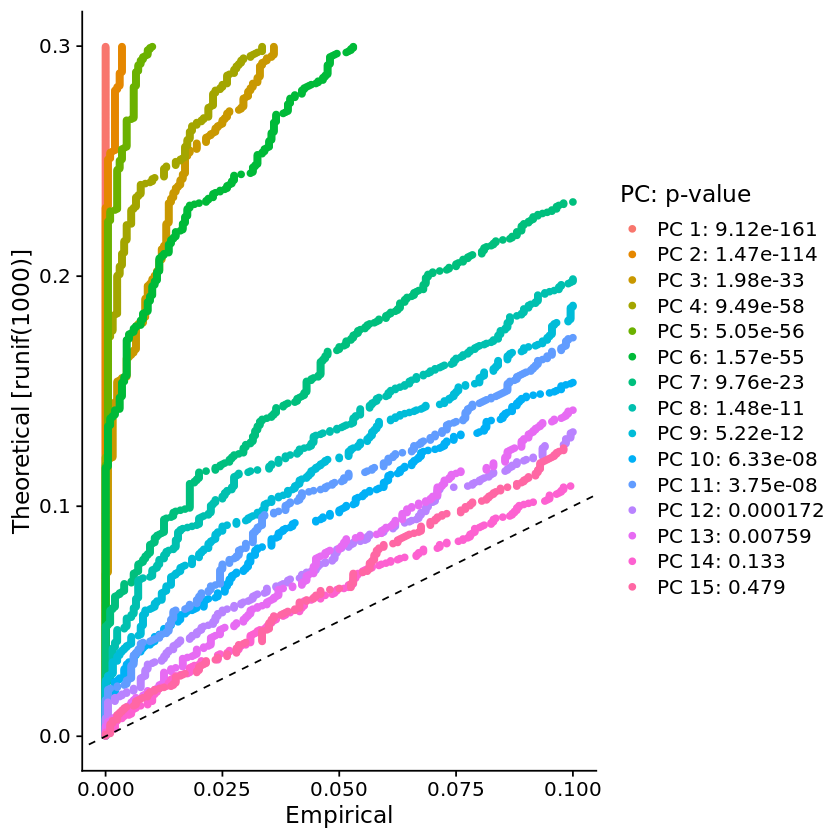

In [20]:
JackStrawPlot(pbmc, dims = 1:15)

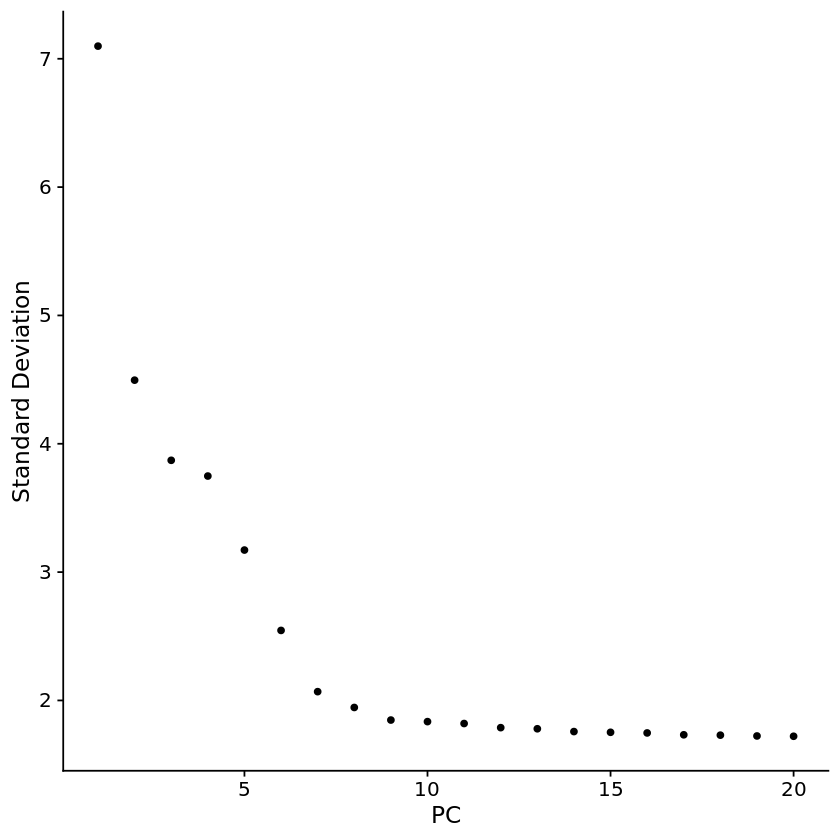

In [21]:
ElbowPlot(pbmc)

## Cluster the cells

In [22]:
pbmc <- FindNeighbors(pbmc, dims = 1:10)
pbmc <- FindClusters(pbmc, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 95927

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8728
Number of communities: 9
Elapsed time: 0 seconds


In [23]:
# Look at cluster IDs of the first 5 cells
head(Idents(pbmc), 5)

AAACATACAACCAC-1 AAACATTGAGCTAC-1 AAACATTGATCAGC-1 AAACCGTGCTTCCG-1 
               2                3                2                1 
AAACCGTGTATGCG-1 
               6 
Levels: 0 1 2 3 4 5 6 7 8

## Run non-linear dimensional reduction (UMAP/tSNE)

In [24]:
pbmc <- RunUMAP(pbmc, dims = 1:10)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
21:28:45 UMAP embedding parameters a = 0.9922 b = 1.112

21:28:45 Read 2638 rows and found 10 numeric columns

21:28:45 Using Annoy for neighbor search, n_neighbors = 30

21:28:45 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:28:46 Writing NN index file to temp file /tmp/mbarcen1/36494479/RtmpZLpRXf/fileab7cd5dbcc2f2

21:28:46 Searching Annoy index using 1 thread, search_k = 3000

21:28:46 Annoy recall = 100%

21:28:47 Commencing smooth kNN distance calibration using 1 thread
 with t

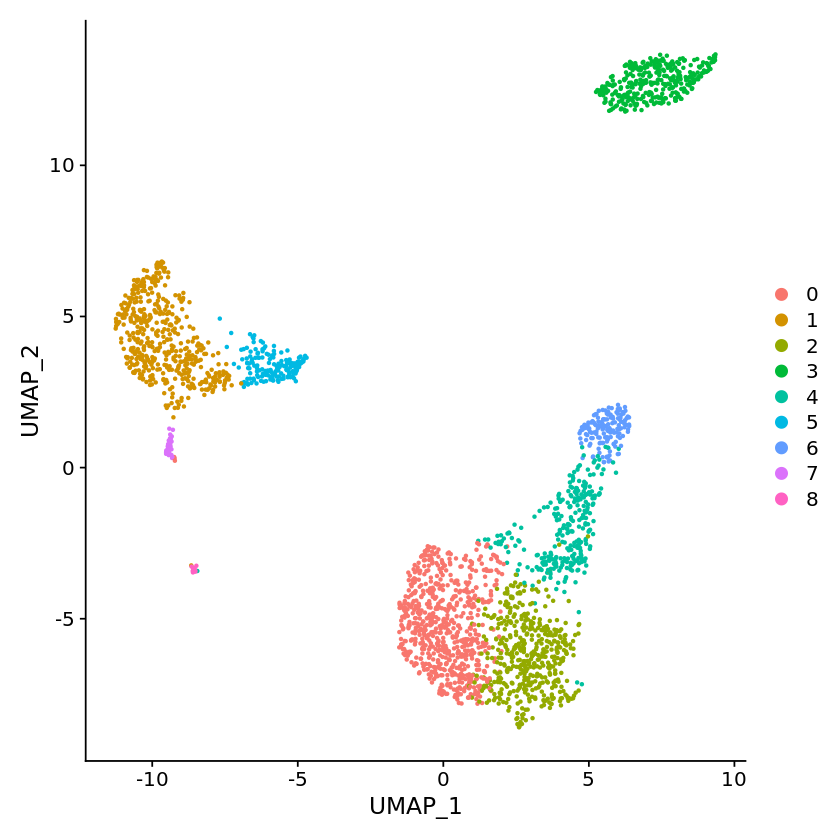

In [25]:
# note that you can set `label = TRUE` or use the LabelClusters function to help label
# individual clusters
DimPlot(pbmc, reduction = "umap")

In [27]:
SaveObject(pbmc, "pbmc_tutorial")
# from seurat turorial below
# saveRDS(pbmc, file = "../output/pbmc_tutorial.rds")

## Finding differentially expressed features (cluster biomarkers)

In [28]:
# find all markers of cluster 2
cluster2.markers <- FindMarkers(pbmc, ident.1 = 2, min.pct = 0.25)
head(cluster2.markers, n = 5)

For a more efficient implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the limma package
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('limma')
--------------------------------------------
After installation of limma, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session



,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IL32,2.892340e-90,1.2013522,0.947,0.465,3.966555e-86
LTB,1.060121e-86,1.2695776,0.981,0.643,1.453850e-82
CD3D,8.794641e-71,0.9389621,0.922,0.432,1.206097e-66
IL7R,3.516098e-68,1.1873213,0.750,0.326,4.821977e-64
LDHB,1.642480e-67,0.8969774,0.954,0.614,2.252497e-63


In [29]:
# find all markers distinguishing cluster 5 from clusters 0 and 3
cluster5.markers <- FindMarkers(pbmc, ident.1 = 5, ident.2 = c(0, 3), min.pct = 0.25)
head(cluster5.markers, n = 5)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FCGR3A,8.246578e-205,4.261495,0.975,0.040,1.130936e-200
IFITM3,1.677613e-195,3.879339,0.975,0.049,2.300678e-191
CFD,2.401156e-193,3.405492,0.938,0.038,3.292945e-189
CD68,2.900384e-191,3.020484,0.926,0.035,3.977587e-187
RP11-290F20.3,2.513244e-186,2.720057,0.840,0.017,3.446663e-182


In [30]:
# find markers for every cluster compared to all remaining cells, report only the positive
# ones
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
pbmc.markers %>%
    group_by(cluster) %>%
    slice_max(n = 2, order_by = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
9.571984e-88,1.358977,0.447,0.108,1.312702e-83,0,CCR7
3.746131e-112,1.085056,0.912,0.592,5.137444e-108,0,LDHB
0.000000e+00,5.571681,0.996,0.215,0.000000e+00,1,S100A9
0.000000e+00,5.476844,0.975,0.121,0.000000e+00,1,S100A8
1.060121e-86,1.269578,0.981,0.643,1.453850e-82,2,LTB
2.966019e-58,1.227797,0.420,0.111,4.067598e-54,2,AQP3
0.000000e+00,4.310172,0.936,0.041,0.000000e+00,3,CD79A
9.481783e-271,3.591579,0.622,0.022,1.300332e-266,3,TCL1A
5.611855e-202,3.099672,0.983,0.234,7.696099e-198,4,CCL5


In [31]:
cluster0.markers <- FindMarkers(pbmc, ident.1 = 0, logfc.threshold = 0.25, test.use = "roc", only.pos = TRUE)

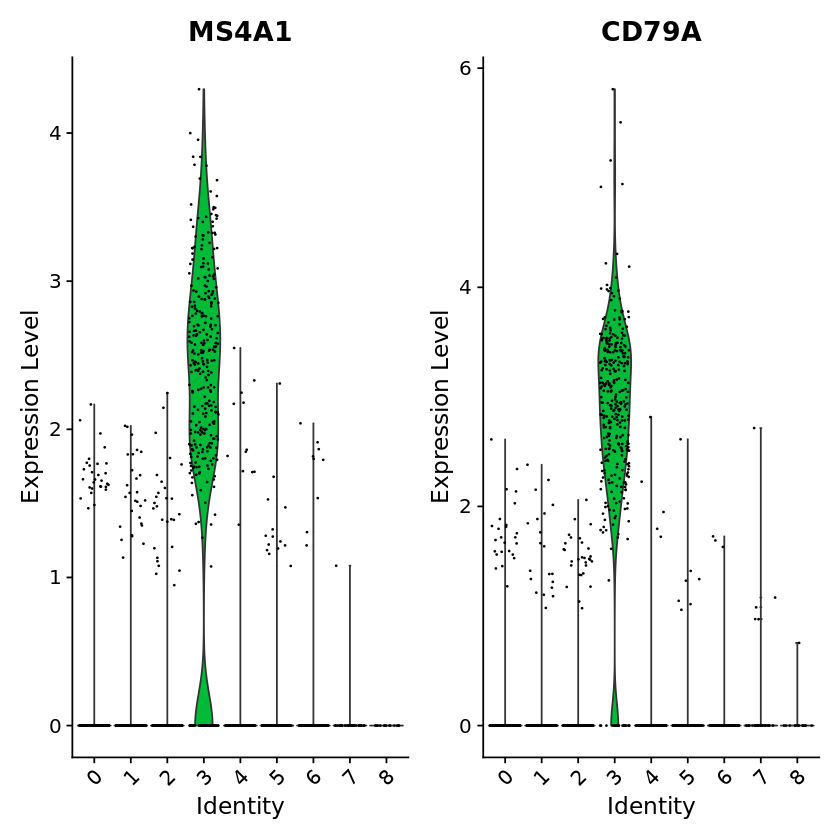

In [32]:
VlnPlot(pbmc, features = c("MS4A1", "CD79A"))

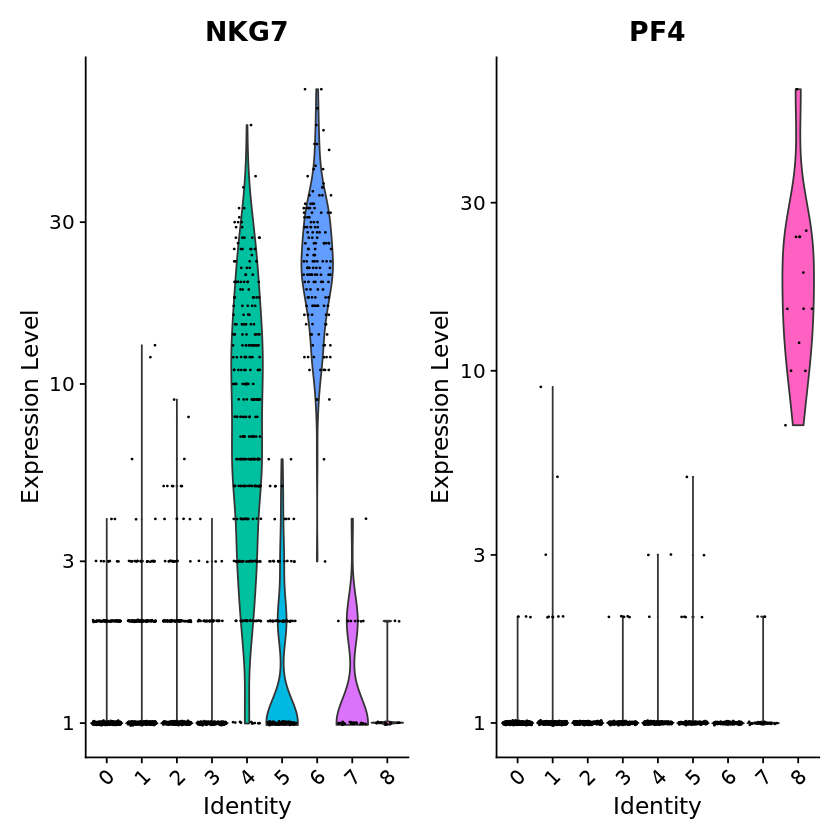

In [33]:
# you can plot raw counts as well
VlnPlot(pbmc, features = c("NKG7", "PF4"), slot = "counts", log = TRUE)

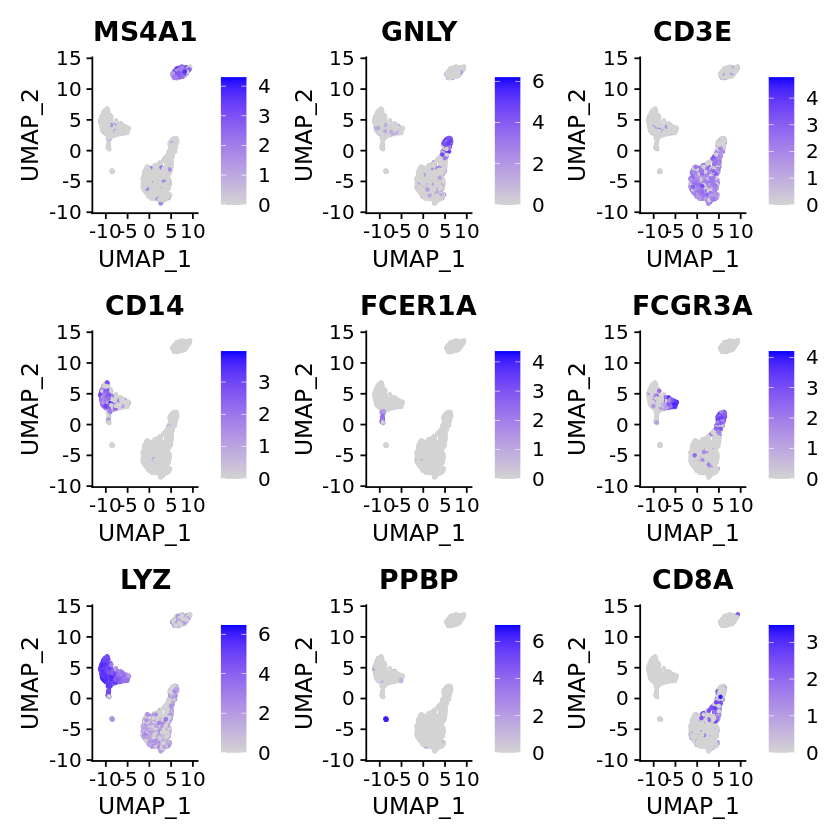

In [34]:
FeaturePlot(pbmc, features = c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP",
    "CD8A"))

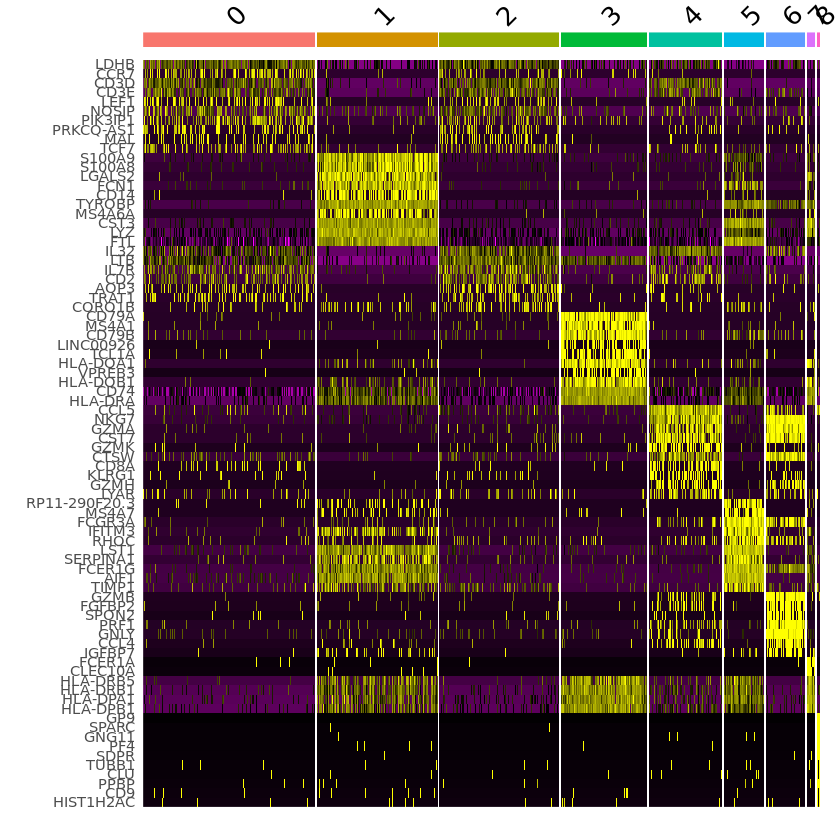

In [35]:
pbmc.markers %>%
    group_by(cluster) %>%
    top_n(n = 10, wt = avg_log2FC) -> top10
DoHeatmap(pbmc, features = top10$gene) + NoLegend()

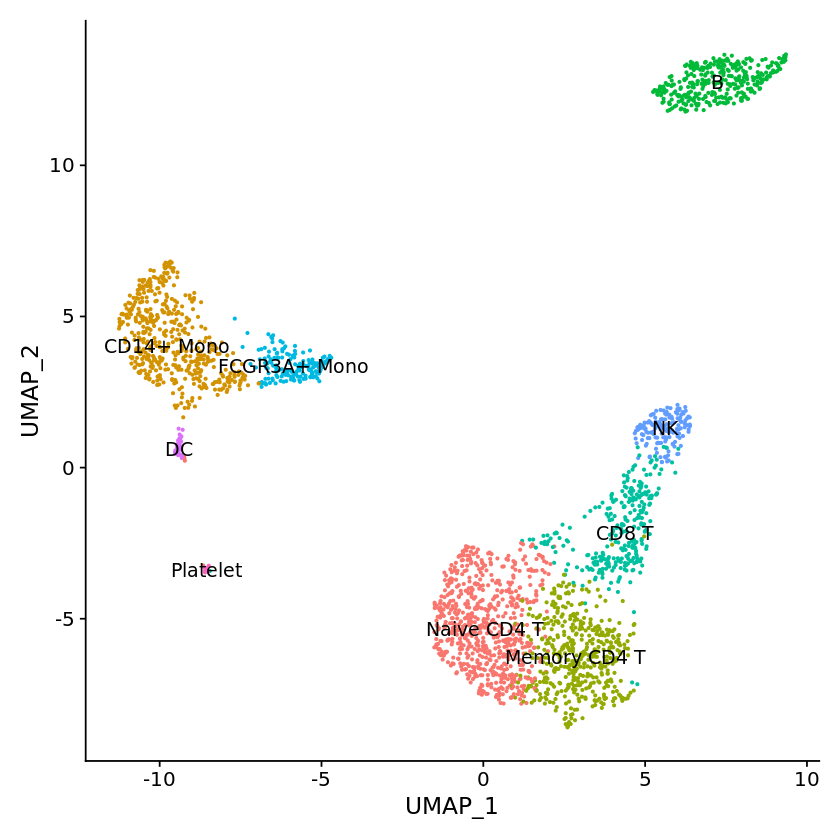

In [36]:
new.cluster.ids <- c("Naive CD4 T", "CD14+ Mono", "Memory CD4 T", "B", "CD8 T", "FCGR3A+ Mono",
    "NK", "DC", "Platelet")
names(new.cluster.ids) <- levels(pbmc)
pbmc <- RenameIdents(pbmc, new.cluster.ids)
DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()

In [37]:
SaveObject(pbmc, "pbmc3k_final")
# Seurat tutorial below
# saveRDS(pbmc, file = "../output/pbmc3k_final.rds")